# Anomaly detection using Vision Transformers - Test

Fine-tune Vision Transformers for Anomaly detection using video frames.

In [1]:
%%capture
pip install git+https://github.com/huggingface/transformers.git

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

In [3]:
%pip install einops
import torch
from einops import reduce, rearrange
import numpy as np
import matplotlib.pyplot as plt
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
model_rep = '/content/drive/MyDrive/Colab Notebooks/ADViTUNet/Models/Model_ped1'

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_rep)
model = ViTForImageClassification.from_pretrained(model_rep, output_attentions=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [19]:
cp -r '/content/drive/MyDrive/Colab Notebooks/ADViTUNet/Data/TestViT/' '/content/Data/'

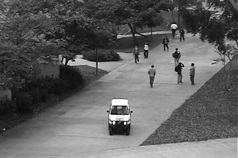

In [24]:
frame1 = Image.open('/content/Data/TestViT/120.jpg') #abnormal frame example
# frame1 = Image.open('/content/Data/TestViT/048.jpg') #normal frame example
display(frame1)

In [15]:
def plotAttentionMap(frame, attention):

  attentions = attention
  att_mat = torch.stack(attentions).squeeze(1)

  # attention
  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')
  im = np.array(frame)

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

  # Attention from the output token to the input space.
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), (im.shape[1], im.shape[0]))[..., np.newaxis]
  result = (mask * im).astype("uint8")

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 14))
  ax1.axis(False), ax2.axis(False), ax3.axis(False)

  alpha=0.3
  beta = (1.0 - alpha)

  ax1.set_title('Original')
  ax2.set_title('Attention Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(im)
  _ = ax2.imshow(result)
  _ = ax3.imshow(im, alpha = 0.8)
  _ = ax3.imshow(mask.squeeze(), alpha = 0.4,cmap='jet')

  from mpl_toolkits.axes_grid1 import make_axes_locatable

  divider = make_axes_locatable(ax3)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(_, cax=cax)

**Test :**

In [ ]:
import time
s_time=time.time()
frame_test=frame1
inputs = feature_extractor(images=frame_test, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
attention = outputs.attentions
predicted_class_idx = logits.argmax(-1).item()
pred_class=model.config.id2label[predicted_class_idx]
print("Predicted class:", pred_class)
r_time = (time.time()-s_time)
print("Run time",r_time)

Predicted class: abnormal
Run time 0.9290943145751953


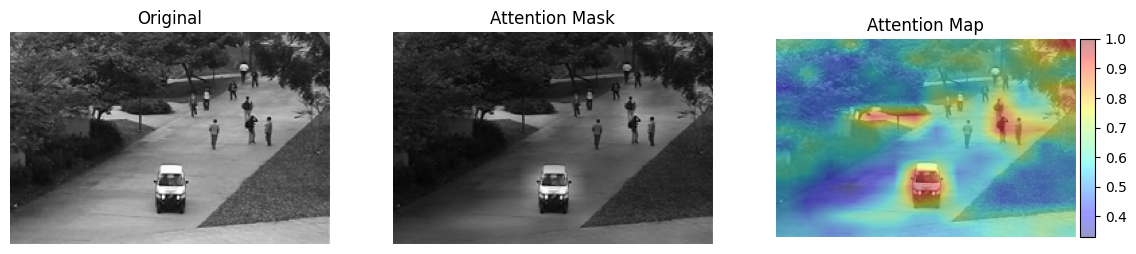

In [ ]:
class_name1=pred_class
if(class_name1=="abnormal"):
  class_name2 = "Abnormal"
  plotAttentionMap(frame1, attention)
else:
  class_name2='Normal'


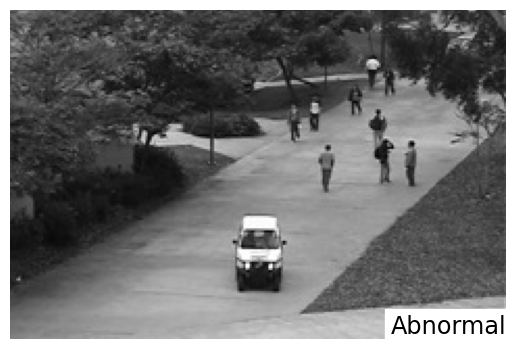

In [ ]:
import matplotlib.pyplot as plt
plt.figure()

ax = plt.gca()
ax.set_title(class_name2,size='xx-large',pad=4,loc='right',y=0,backgroundcolor='white')
ax.axis('off')
plt.imshow(frame1)